In [1]:
from Module_241021 import (equations_NGEO_and_F,
                           equations_NGEOF_and_maOE,
                           par0909,
                           generate_ic_to_scan_deterministic_triangle,
                           condition_2
                          )

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import scipy as sb
from scipy.integrate import solve_ivp

In [3]:
# generate IC
ICs = generate_ic_to_scan_deterministic_triangle(p=par0909,
                                                 ic_range=[0.1, 5.0],
                                                 N_points_1D=4,#36
                                                 base=2,
                                                 dim=4
                                                ) # G, N, E, O

In [4]:
# sort them whether they are Epi or PrE primed cells.
lst_primed_epi = ICs[ICs[:, 0] > ICs[:, 1]]  # nanog > gata6
lst_primed_pre = ICs[ICs[:, 0] < ICs[:, 1]]  # nanog < gata6

In [9]:
def func_bifurcation_diagram_steady_state_111224(model,par,network,date,IC_array,key,dim,
                                                 bifurcation_parameter,
                                                 epi_ref = np.array([1.1, 11.5]),
                                                 pre_ref = np.array([13.6, 2.4]),
                                                 bstart=None,bstop=None,b_num=50, threshold=0.2
                                         ):
    
    '''
    samples data to bifurcation diagrams for "model" as function of fgf4.
    the data is saved in a csv file named "{key}_dependence_data_{network}_{date}.csv"
    steady state values using solve_ivp.
    
    
    11.12.24
    key = string, bifurcation parameter, key name in the dictionary named "par"
    '''
    
    def func_steady_state(model, par, ic):
        sol = solve_ivp(model, (0,200), ic, args=[par])
        return sol.y[:,-1]
    
    def abs_deviation(coord, reference):
                """
                coord    : np.array()
                reference: np.array()
                """
                return np.abs((coord - reference)/reference)
            
            
    # 0.0 save par
    ref_par = par.copy()
    
    # 0.1 define bifurcation parameter range
    if bifurcation_parameter.any()==None:
        if bstart==None or bstop==None:
            
            print("WARNING bifurcation_parameter is not None. Define bstart and bstop")
        else:
            bifurcation_parameter = np.logspace(np.log2(bstart), np.log2(bstop), num=b_num, base=2)
    
    # 1.0 sample bifurcation data to external csv file.
    all_data = []
    
    for par_value in bifurcation_parameter:
        
        # 0. update bifurcation parameter value
        if key == "K_ON" or key == "K_NO":
            par["K_NO"]=par_value
            par["K_ON"]=par_value
        
        elif key == "K_EO" or key == "K_OE":
            par["K_EO"]=par_value
            par["K_OE"]=par_value
        
        else:
            par[key]=par_value
        
        for ic in IC_array:
            # to acommodate that I sample all ics regardless, practical issue.
            if dim==2:
                esrrb=0
                oct4=0
            if dim==3:
                esrrb=ic[2]
                oct4=0
            if dim==4:
                esrrb=ic[2]
                oct4=ic[3]
            
            steady_state = func_steady_state(model=model, par=par, ic=ic)
            
            # to acommodate that I sample all ics regardless.
            if dim==2:
                ss_esrrb=0
                ss_oct4=0
            if dim==3:
                ss_esrrb=steady_state[2]
                ss_oct4=0
            if dim==4:
                ss_esrrb=steady_state[2]
                ss_oct4=steady_state[3]
            
            
            # categorize states
            if np.all(abs_deviation(steady_state[:2], epi_ref) <= threshold):
                state="epi"
            elif np.all(abs_deviation(steady_state[:2], pre_ref) <= threshold):
                state="pre"
            else:
                state="undefined"
            
            # sample the data
            data = {
                "network": network,
                "parameter": key,
                "par value": par_value,
                "ic gata6": ic[0],
                "ic nanog": ic[1],
                "ic esrrb": esrrb,
                "ic oct4": oct4,
                "ss gata6": steady_state[0],
                "ss nanog": steady_state[1],
                "ss esrrb": ss_esrrb,
                "ss oct4": ss_oct4,
                "state": state
            }
            
            all_data.append(data)
    
    # reset par
    par = ref_par.copy()
    # create dateframe
    bifurcation_data_df = pd.DataFrame(all_data)
    
    # Calculate the fraction of each state ("epi", "pre", "undefined") for each par_value
    state_counts = bifurcation_data_df.groupby(['par value', 'state']).size().unstack(fill_value=0)
    
    # Calculate fractions
    state_percentages = state_counts.div(state_counts.sum(axis=1), axis=0)
    
    state_percentages = state_percentages.reindex(columns=["epi", "pre", "undefined"], fill_value=0)

    # Merge the state percentages with the original DataFrame
    bifurcation_data_df = pd.merge(bifurcation_data_df, state_percentages[['epi', 'pre', 'undefined']],
                                    left_on='par value', right_index=True, how='left')
    
    
    bifurcation_data_df.to_csv(f"{key}_dependence_data_{network}_{date}.csv", index=False)
    print(f"{key} dependece data is saved to {key}_dependence_data_{network}_{date}.csv")

In [47]:
scale_factors = np.array([0.2, 0.25, 0.5, 0.75, 1.0, 1.25, 2.0, 3.0, 4.0, 5.0])
bifur_range_kog = par0909["K_OG"]*scale_factors
bifur_range_kon = par0909["K_ON"]*scale_factors
bifur_range_koe = par0909["K_OE"]*scale_factors

In [32]:
# KOG
print(bifur_range_kog)
func_bifurcation_diagram_steady_state_111224(model=equations_NGEO_and_F,
                                             par=par0909,
                                             network="GNEO 1",
                                             date="111224",
                                             IC_array=lst_primed_epi,
                                             key="K_OG",
                                             dim=4,
                                             bifurcation_parameter=bifur_range_kog
                                      )

[0.24 0.3  0.6  0.9  1.2  1.5  2.4  3.6  4.8  6.  ]
K_OG dependece data is saved to K_OG_dependence_data_GNEO 1_111224.csv


In [33]:
primed_epi_data=pd.read_csv("K_OG_dependence_data_GNEO 1_111224.csv")

In [35]:
print(par0909["K_OG"])
primed_epi_data["par value"].unique()

6.0


,network,parameter,par value,ic gata6,ic nanog,ic esrrb,ic oct4,ss gata6,ss nanog,ss esrrb,ss oct4,state,epi,pre,undefined
0,GNEO 1,K_OG,0.24,0.368403,0.100000,0.994172,13.0,13.601672,2.425534,12.309628,12.320411,pre,0,1.0,0
1,GNEO 1,K_OG,0.24,1.357209,0.100000,0.994172,13.0,13.606211,2.426140,12.307264,12.318062,pre,0,1.0,0
2,GNEO 1,K_OG,0.24,1.357209,0.368403,1.098586,13.0,13.604033,2.425847,12.308404,12.319195,pre,0,1.0,0
3,GNEO 1,K_OG,0.30,0.368403,0.100000,0.994172,13.0,13.601670,2.425534,12.309628,12.320411,pre,0,1.0,0
4,GNEO 1,K_OG,0.30,1.357209,0.100000,0.994172,13.0,13.606210,2.426140,12.307264,12.318062,pre,0,1.0,0
5,GNEO 1,K_OG,0.30,1.357209,0.368403,1.098586,13.0,13.604031,2.425847,12.308404,12.319195,pre,0,1.0,0
6,GNEO 1,K_OG,0.60,0.368403,0.100000,0.994172,13.0,13.601609,2.425537,12.309628,12.320411,pre,0,1.0,0
7,GNEO 1,K_OG,0.60,1.357209,0.100000,0.994172,13.0,13.606162,2.426145,12.307257,12.318055,pre,0,1.0,0
8,GNEO 1,K_OG,0.60,1.357209,0.368403,1.098586,13.0,13.603978,2.425851,12.308400,12.319191,pre,0,1.0,0
9,GNEO 1,K_OG,0.90,0.368403,0.100000,0.994172,13.0,13.601420,2.425545,12.309633,12.320416,pre,0,1.0,0


In [45]:
def prepare_df_to_stacked_bar_chart(df):
    
    # Group by "par value" and aggregate values for each category
    grouped = df.groupby("par value").mean()

    # Create the dictionary
    ratios = {
        category: grouped[category].values
        for category in ["epi", "pre", "undefined"]
    }
    return ratios



('0.2', '0.25', '0.5', '0.75', '1.0', '1.25', '2.0', '3.0', '4.0', '5.0')

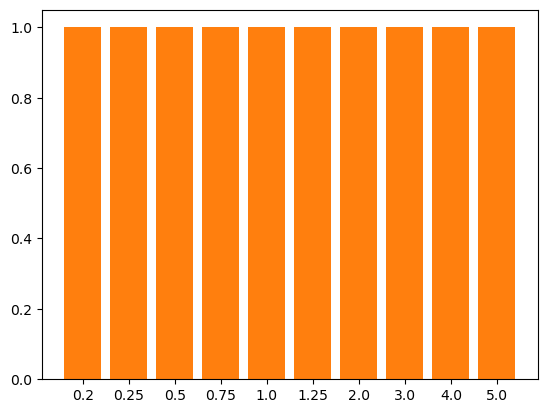

In [59]:
fig, ax = plt.subplots()
x = tuple(map(str,scale_factors))
y = prepare_df_to_stacked_bar_chart(primed_epi_data[["par value","epi","pre","undefined"]])
colors = {"epi": "green", "pre": "red","undefined":"yellow"} 

for name, ratio in y.items():
    ax.bar(x, ratio, label=name)





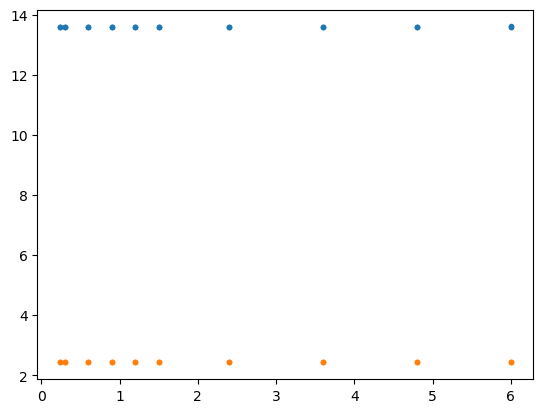

In [13]:
plt.plot(primed_epi_data["par value"], primed_epi_data["ss gata6"], ".")
plt.plot(primed_epi_data["par value"], primed_epi_data["ss nanog"], ".")


In [49]:
primed_epi_data[["ss gata6", "ss nanog"]]

,ss gata6,ss nanog
0,13.601673,2.425534
1,13.606212,2.426139
2,13.604034,2.425847
3,13.601673,2.425534
4,13.606212,2.426139
...,...,...
145,13.605652,2.426204
146,13.605357,2.426165
147,13.601322,2.425625
148,13.605660,2.426205


In [48]:
primed_epi_data["par value"].unique()

array([0.2       , 0.21357941, 0.22808082, 0.24356684, 0.26010431,
       0.27776463, 0.29662402, 0.31676392, 0.33827126, 0.36123888,
       0.38576594, 0.41195831, 0.43992906, 0.46979895, 0.50169691,
       0.53576065, 0.57213722, 0.61098365, 0.65246764, 0.69676827,
       0.74407678, 0.7945974 , 0.84854823, 0.90616215, 0.96768789,
       1.03339105, 1.10355525, 1.1784834 , 1.25849895, 1.34394732,
       1.43519738, 1.53264305, 1.636705  , 1.74783245, 1.86650512,
       1.99323532, 2.12857012, 2.27309376, 2.42743012, 2.59224547,
       2.7682513 , 2.95620741, 3.15692518, 3.37127109, 3.60017046,
       3.84461143, 4.10564921, 4.3844107 , 4.68209926, 5.        ])